In [1]:
import argparse
import os
import sys
import tensorflow as tf
from model import build_EfficientPose
from eval.common import evaluate

In [2]:
#python evaluate.py --phi 0 --weights ./Weights/Linemod/object_9/phi_0_linemod_best_ADD.h5 --validation-image-save-path ./predicted_images linemod D:/dataset/Linemod_preprocessed --object-id 9

In [3]:
args = '--phi 0 --weights ./Weights/Linemod/object_9/phi_0_linemod_best_ADD.h5 --validation-image-save-path ./predicted_images linemod D:/dataset/Linemod_preprocessed --object-id 9'.split(' ')

In [4]:
def parse_args(args):
    """
    Parse the arguments.
    """
    parser = argparse.ArgumentParser(description='Simple EfficientPose evaluation script.')
    subparsers = parser.add_subparsers(help = 'Arguments for specific dataset types.', dest='dataset_type')
    subparsers.required = True
    
    linemod_parser = subparsers.add_parser('linemod')
    linemod_parser.add_argument('linemod_path', help = 'Path to dataset directory (ie. /Datasets/Linemod_preprocessed).')
    linemod_parser.add_argument('--object-id', help = 'ID of the Linemod Object to train on', type = int, default = 8)
    
    occlusion_parser = subparsers.add_parser('occlusion')
    occlusion_parser.add_argument('occlusion_path', help = 'Path to dataset directory (ie. /Datasets/Linemod_preprocessed).')

    parser.add_argument('--rotation-representation', help = 'Which representation of the rotation should be used. Choose from "axis_angle", "rotation_matrix" and "quaternion"', default = 'axis_angle')

    parser.add_argument('--weights', help = 'File containing weights to init the model parameter')

    parser.add_argument('--batch-size', help = 'Size of the batches.', default = 1, type = int)
    parser.add_argument('--phi', help = 'Hyper parameter phi', default = 0, type = int, choices = (0, 1, 2, 3, 4, 5, 6))
    parser.add_argument('--gpu', help = 'Id of the GPU to use (as reported by nvidia-smi).')
    parser.add_argument('--score-threshold', help = 'score threshold for non max suppresion', type = float, default = 0.5)
    parser.add_argument('--validation-image-save-path', help = 'path where to save the predicted validation images after each epoch', default = None)
    
    print(vars(parser.parse_args(args)))
    return parser.parse_args(args)

In [5]:
def allow_gpu_growth_memory():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    _ = tf.Session(config = config)

In [6]:
allow_gpu_growth_memory()

In [7]:
args = parse_args(args)

{'dataset_type': 'linemod', 'rotation_representation': 'axis_angle', 'weights': './Weights/Linemod/object_9/phi_0_linemod_best_ADD.h5', 'batch_size': 1, 'phi': 0, 'gpu': None, 'score_threshold': 0.5, 'validation_image_save_path': './predicted_images', 'linemod_path': 'D:/dataset/Linemod_preprocessed', 'object_id': 9}


In [8]:
if args.validation_image_save_path:
    os.makedirs(args.validation_image_save_path, exist_ok = True)

In [9]:
def create_generators(args):
    common_args = {
        'batch_size': args.batch_size,
        'phi': args.phi,
    }
    
    from generators.linemod import LineModGenerator
    generator = LineModGenerator(
        args.linemod_path,
        args.object_id,
        train = False,
        shuffle_dataset = False,
        shuffle_groups = False,
        rotation_representation = args.rotation_representation,
        use_colorspace_augmentation = False,
        use_6DoF_augmentation = False,
        **common_args
    )
    return generator  

In [10]:
print("\nCreating the Generators...")
generator = create_generators(args)
print("Done!")


Creating the Generators...
Done!


In [11]:
num_rotation_parameters = generator.get_num_rotation_parameters()
num_classes = generator.num_classes()
num_anchors = generator.num_anchors

In [12]:
print("\nBuilding the Model...")
_, prediction_model, _ = build_EfficientPose(args.phi,
                                             num_classes = num_classes,
                                             num_anchors = num_anchors,
                                             freeze_bn = True,
                                             score_threshold = args.score_threshold,
                                             num_rotation_parameters = num_rotation_parameters,
                                             print_architecture = False)
print("Done!")


Building the Model...
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Done!


In [13]:
print('Loading model, this may take a second...')
prediction_model.load_weights(args.weights, by_name = True)
print("\nDone!")

Loading model, this may take a second...

Done!


In [14]:
model = prediction_model
generator = generator
save_path = args.validation_image_save_path
score_threshold = args.score_threshold
iou_threshold = 0.5
max_detections = 100
diameter_threshold = 0.1

In [145]:
i = 0
raw_image    = generator.load_image(i)
image, scale = generator.preprocess_image(raw_image.copy())
# image, scale = generator.resize_image(image)
camera_matrix = generator.load_camera_matrix(i)
camera_input = generator.get_camera_parameter_input(camera_matrix, scale, generator.translation_scale_norm)

In [16]:
camera_matrix

array([[572.4114 ,   0.     , 325.2611 ],
       [  0.     , 573.57043, 242.04899],
       [  0.     ,   0.     ,   1.     ]])

In [17]:
import numpy as np
boxes, scores, labels, rotations, translations = model.predict_on_batch(
    [np.expand_dims(image, axis=0), np.expand_dims(camera_input, axis=0)])[:5]

In [18]:
import math
# correct boxes for image scale
boxes /= scale

#rescale rotations and translations
rotations *= math.pi
height, width, _ = raw_image.shape

# select indices which have a score above the threshold
indices = np.where(scores[0, :] > score_threshold)[0]

# select those scores
scores = scores[0][indices]

# find the order with which to sort the scores
scores_sort = np.argsort(-scores)[:max_detections]

# select detections
image_boxes      = boxes[0, indices[scores_sort], :]
image_rotations  = rotations[0, indices[scores_sort], :]
image_translations = translations[0, indices[scores_sort], :]
image_scores     = scores[scores_sort]
image_labels     = labels[0, indices[scores_sort]]
image_detections = np.concatenate([image_boxes, np.expand_dims(image_scores, axis=1), np.expand_dims(image_labels, axis=1)], axis=1)

In [19]:
image_boxes

array([[333.19424, 239.93979, 403.66223, 297.64447]], dtype=float32)

In [20]:
image_rotations

array([[-3.8265224 ,  0.14219365, -0.23086023]], dtype=float32)

In [21]:
image_translations

array([[ 65.36677 ,  30.279516, 824.9473  ]], dtype=float32)

In [22]:
image_scores

array([1.], dtype=float32)

In [23]:
image_detections

array([[333.19424438, 239.93978882, 403.66223145, 297.64447021,
          1.        ,   0.        ]])

In [146]:
import cv2
from utils.visualization import draw_detections, draw_annotations
raw_image    = generator.load_image(i)
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_RGB2BGR)
# draw_annotations(raw_image, generator.load_annotations(i), class_to_bbox_3D = generator.get_bbox_3d_dict(), camera_matrix = generator.load_camera_matrix(i), label_to_name=generator.label_to_name)
draw_detections(raw_image, image_boxes, image_scores, image_labels, image_rotations, image_translations, class_to_bbox_3D = generator.get_bbox_3d_dict(), camera_matrix = generator.load_camera_matrix(i), label_to_name=generator.label_to_name)

cv2.imwrite('1.png', raw_image)

True

In [65]:
image, boxes, scores, labels, rotations, translations = raw_image, image_boxes, image_scores, image_labels, image_rotations, image_translations
class_to_bbox_3D = generator.get_bbox_3d_dict()
camera_matrix = generator.load_camera_matrix(i)
label_to_name=generator.label_to_name
score_threshold = 0.5
draw_bbox_2d = False
draw_name = False

In [66]:
selection = np.where(scores > score_threshold)[0]

In [74]:
# for i in selection:
i = selection[0]
c = [255 , 95  , 0]
translation_vector = translations[i, :]

In [86]:
def project_bbox_3D_to_2D(points_bbox_3D, rotation_vector, translation_vector, camera_matrix, append_centerpoint = True):
    """ Projects the 3D model's cuboid onto a 2D image plane with the given rotation, translation and camera matrix.

    Arguments:
        points_bbox_3D: numpy array with shape (8, 3) containing the 8 (x, y, z) corner points of the object's 3D model cuboid 
        rotation_vector: numpy array containing the rotation vector with shape (3,)
        translation_vector: numpy array containing the translation vector with shape (3,)
        camera_matrix: numpy array with shape (3, 3) containing the intrinsic camera parameters
        append_centerpoint: Boolean indicating wheter to append the centerpoint or not
    Returns:
        points_bbox_2D: numpy array with shape (8 or 9, 2) with the 2D projections of the object's 3D cuboid
    """
    if append_centerpoint:
        points_bbox_3D = np.concatenate([points_bbox_3D, np.zeros(shape = (1, 3))], axis = 0)
    points_bbox_2D, jacobian = cv2.projectPoints(points_bbox_3D, rotation_vector, translation_vector, camera_matrix, None)
    points_bbox_2D = np.squeeze(points_bbox_2D)
    
    return points_bbox_2D

In [87]:
points_bbox_2D = project_bbox_3D_to_2D(class_to_bbox_3D[labels[i]], rotations[i, :], translation_vector, camera_matrix, append_centerpoint = True)

In [85]:
xhy = np.array(list(zip(xlist, ylist, zlist)))

In [97]:
points_bbox_2D_xhy, jacobian = cv2.projectPoints(xhy, rotations[i, :], translation_vector, camera_matrix, None)

In [147]:
xhy_img = np.zeros((480, 640, 3))
xhy_img_br = np.zeros((480, 640, 3))

In [148]:
for i in points_bbox_2D_xhy:
    xhy_img[int(i[0,1]), int(i[0,0])] = (0,0,255)
    xhy_img_br[int(i[0,1]), int(i[0,0])] = (1,1,1)

In [149]:
img_xhy = np.where(xhy_img_br, xhy_img, raw_image)

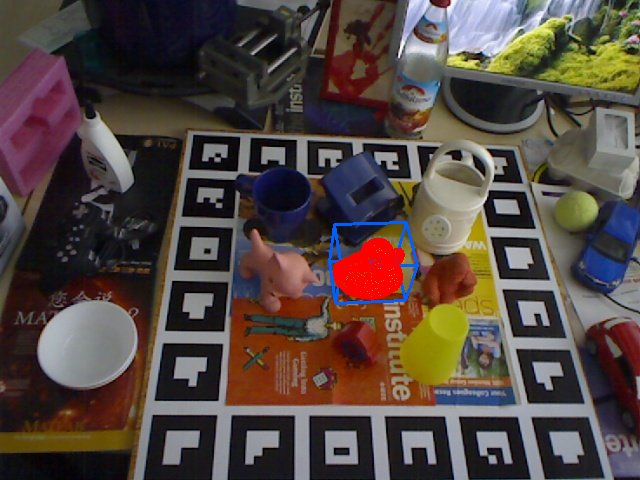

In [150]:
Image.fromarray(np.uint8(img_xhy[...,::-1]))

In [71]:
generator.load_annotations(i)

{'labels': array([0.]),
 'bboxes': array([[272., 121., 400., 237.]]),
 'rotations': array([[ 2.30665044, -0.09614927, -0.19276978,  0.        ,  0.        ]]),
 'translations': array([[  27.8543177 , -110.12161613, 1023.44225463]]),
 'translations_x_y_2D': array([[340.84002389, 180.33324353]])}

In [95]:
generator.get_bbox_3d_dict()

{0: array([[-52.2146, -38.7038, -42.8485],
        [ 52.2146, -38.7038, -42.8485],
        [ 52.2146,  38.7038, -42.8485],
        [-52.2146,  38.7038, -42.8485],
        [-52.2146, -38.7038,  42.8485],
        [ 52.2146, -38.7038,  42.8485],
        [ 52.2146,  38.7038,  42.8485],
        [-52.2146,  38.7038,  42.8485]])}

C:\ProgramData\Anaconda3\envs\EfficientPose\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  from ipykernel import kernelapp as app


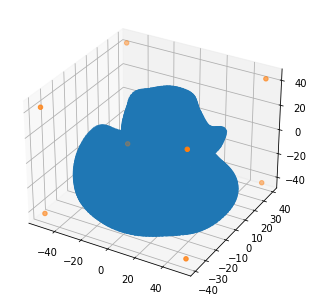

In [94]:
import matplotlib.pyplot as plt
from plyfile import PlyData
from mpl_toolkits.mplot3d import Axes3D

plydata = PlyData.read('D:\dataset\Linemod_preprocessed\models\obj_09.ply')

xlist = plydata['vertex']['x']
ylist = plydata['vertex']['y']
zlist = plydata['vertex']['z']
x_box = class_to_bbox_3D[0][:,0]
y_box = class_to_bbox_3D[0][:,1]
z_box = class_to_bbox_3D[0][:,2]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xlist, ylist, zlist)
ax.scatter(x_box, y_box, z_box)
plt.show()

array([-52.2146,  52.2146,  52.2146, -52.2146, -52.2146,  52.2146,
        52.2146, -52.2146])

In [82]:
vertex = plydata['vertex']
points_3d = np.stack([vertex[:]['x'], vertex[:]['y'], vertex[:]['z']], axis = -1)

In [84]:
points_3d.shape

(7912, 3)

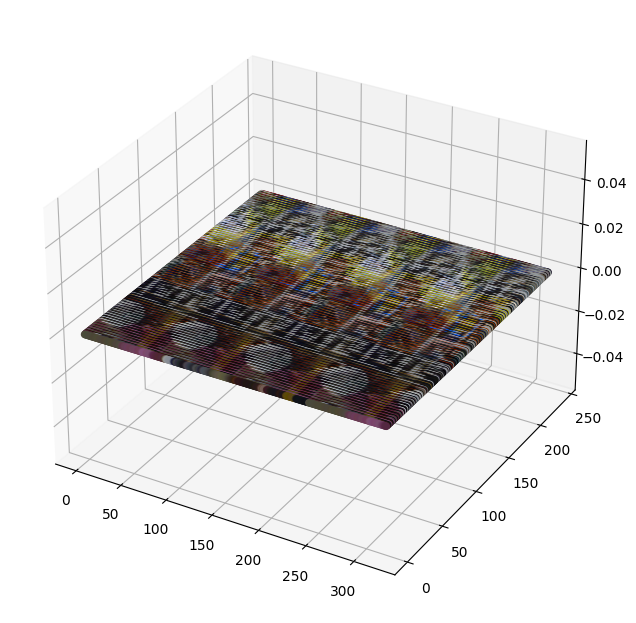

In [51]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
 
# 创建3D对象
fig = plt.figure(figsize=(20,8),dpi=100)
ax = fig.add_subplot(111, projection='3d')
 
# 读取图片
img = Image.open('1.png').convert('RGB').resize((320, 240))
pix = img.load()
# 获取图片长宽
width = img.size[0]
height = img.size[1]
# 创建x,y轴的长度
x = np.arange(0,width)
y = np.arange(0,height)
x,y = np.meshgrid(x,y)
# x = x.reshape(-1)
# y = y.reshape(-1)
z = np.zeros((width,height))
# 建立列表，后期使用
color = []
# 遍历长宽，获得每个像素点的RGB值
for i in range(width):
    for j in range(height):
        # 转化rgb为相对占比的元组
        rgb= tuple(np.array(pix[i, j])/255)
        color.append(rgb)

# 在z=0的平面上作图
 
# 设置颜色，像素
ax.scatter(x,y,z,c = color,alpha = 1)
plt.show()

In [49]:
pix.

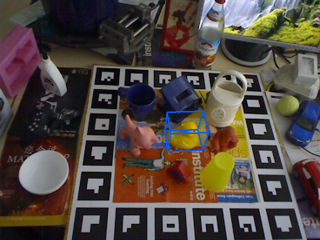

In [52]:
img

In [57]:
color

[(0.30980392156862746, 0.28627450980392155, 0.24705882352941178),
 (0.30196078431372547, 0.29411764705882354, 0.23529411764705882),
 (0.29411764705882354, 0.2980392156862745, 0.2196078431372549),
 (0.28627450980392155, 0.2980392156862745, 0.2235294117647059),
 (0.2901960784313726, 0.29411764705882354, 0.23529411764705882),
 (0.29411764705882354, 0.28627450980392155, 0.23921568627450981),
 (0.2901960784313726, 0.2823529411764706, 0.23137254901960785),
 (0.2901960784313726, 0.2823529411764706, 0.2235294117647059),
 (0.2980392156862745, 0.28627450980392155, 0.23529411764705882),
 (0.29411764705882354, 0.2823529411764706, 0.2235294117647059),
 (0.2901960784313726, 0.2784313725490196, 0.21176470588235294),
 (0.29411764705882354, 0.27058823529411763, 0.20784313725490197),
 (0.2980392156862745, 0.27450980392156865, 0.21176470588235294),
 (0.29411764705882354, 0.2823529411764706, 0.21568627450980393),
 (0.2980392156862745, 0.2901960784313726, 0.20784313725490197),
 (0.30196078431372547, 0.2941

C:\ProgramData\Anaconda3\envs\EfficientPose\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  if sys.path[0] == '':


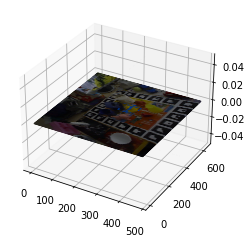

In [62]:
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cbook import get_sample_data
# from matplotlib._png import read_png
import matplotlib.image as mpimg
img = mpimg.imread('1.png')
# fn = get_sample_data("1.png", asfileobj=False)
# img = read_png(fn)
x, y = ogrid[0:img.shape[0], 0:img.shape[1]]

z = np.zeros((img.shape[0],img.shape[1]))
ax = gca(projection='3d')
ax.plot_surface(x, y, z, rstride=5, cstride=5, facecolors=img)
show()

In [64]:
img

array([[[0.3137255 , 0.28627452, 0.24705882],
        [0.3137255 , 0.28627452, 0.24705882],
        [0.30980393, 0.28627452, 0.23921569],
        ...,
        [0.23529412, 0.3137255 , 0.20392157],
        [0.22352941, 0.3137255 , 0.2       ],
        [0.27450982, 0.3647059 , 0.2509804 ]],

       [[0.3137255 , 0.28627452, 0.24705882],
        [0.30588236, 0.2901961 , 0.24313726],
        [0.30980393, 0.28627452, 0.23921569],
        ...,
        [0.19215687, 0.2509804 , 0.16078432],
        [0.21568628, 0.28627452, 0.2       ],
        [0.34509805, 0.41568628, 0.32941177]],

       [[0.30588236, 0.2901961 , 0.24313726],
        [0.3019608 , 0.29411766, 0.23529412],
        [0.29803923, 0.28627452, 0.22745098],
        ...,
        [0.16470589, 0.1882353 , 0.14901961],
        [0.19607843, 0.22352941, 0.19215687],
        [0.3372549 , 0.3764706 , 0.34509805]],

       ...,

       [[0.05882353, 0.07058824, 0.09019608],
        [0.05882353, 0.07058824, 0.09019608],
        [0.0627451 , 0

In [ ]:
# # 注释为国外大佬写的，汉字部分我的补充
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.cbook import get_sample_data
# import cv2
 
# # Read the image with Opencv
# img = cv2.imread('1.png')
# # Change the color from BGR to RGB
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
# # Orgird to store data
# x, y = np.ogrid[0:img.shape[0], 0:img.shape[1]]
# # In Python3 matplotlib assumes rgbdata in range 0.0 to 1.0
# img = img.astype('float32')/255
# fig = plt.Figure()
# # gca do not work thus use figure objects inbuilt function.
# ax = fig.add_subplot(111, projection='3d')
 
# # Plot data
# # rstride，cstride相当于设置图片显示的像素，当两项均等于1的时候相当于我写的程序
# ax.plot_surface(x, y, np.atleast_2d(0), rstride=10, cstride=10, facecolors=img)
# fig.show() # Throws a AttributeError